<h1><center>Bert Base Uncase Model</center></h1>

In [27]:
import os
import transformers
from transformers import BertTokenizerFast, BertForQuestionAnswering, logging
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import string, re

In [28]:
logging.set_verbosity_warning()
logging.set_verbosity_error()

Helper function to format the paragraph for bert module.

In [29]:
class Make_DataSet():
    def __init__(self):
        self.ds = None
    
    def Text(text):
        text = text.replace("]", " ] ")
        text = text.replace("[", " [ ")
        text = text.replace("\n", " ")
        text = text.replace("''", '" ').replace("``", '" ')
        return text

In [30]:
bert_name = 'bert-base-uncased'

Class which import Bert model from transformers python library.

In [31]:
class Model():
    def __init__(self,context):
        self.context = context
        self.input_ids = None
        self.text_tokens = None
        self.outputs = None
        self.segment_ids = None
        self.tokenizer = BertTokenizerFast.from_pretrained(bert_name)
        self.model = BertForQuestionAnswering.from_pretrained(bert_name)


    def get_output(self,question):
        
        self.input_ids = self.tokenizer.encode(question,self.context,max_length=2015,truncation=True)
        tokens = self.tokenizer.convert_ids_to_tokens(self.input_ids)
        
        segment_ids = [0]*(self.input_ids.index(102) + 1) + [1]*(len(self.input_ids)-(self.input_ids.index(102) + 1))
        self.segment_ids = segment_ids
        
        input_ids = torch.tensor([self.input_ids])
        segments_ids = torch.tensor([segment_ids])

        sts_ = self.model(input_ids, token_type_ids = segments_ids)[0]
        ets_ = self.model(input_ids, token_type_ids = segments_ids)[1]
        sts_, ets_ = sts_.detach().numpy().flatten(), ets_.detach().numpy().flatten()
        asi, aei = np.argmax(sts_), np.argmax(ets_)
        
        sts, ets = np.round(sts_[asi],2), np.round(ets_[aei],2) 
        
        answer = tokens[asi] # start index
        
        for i in range(asi+1,aei+1):
            answer += tokens[i][2:] if tokens[i][0:2] == '##' else ' ' +tokens[i]
        
        if(asi ==0) or (sts<0) or (answer == '[SEP]') or (aei < asi):
            answer = "Not Found"
        
        return (asi,aei,sts,ets,sts_,ets_,answer)
    
    def generate_text_from_token(self):
        return self.tokenizer.convert_ids_to_tokens(self.input_ids)
    

Loading the Validation data in proper format.

In [32]:
valid_path = 'dev-v2.0.json'

with open(valid_path, 'rb') as f:
    squad = json.load(f)

valid_contexts, valid_questions,valid_answers = [],[],[]

for group in squad['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                valid_contexts.append(context)
                valid_questions.append(question)
                valid_answers.append(answer)

Function for pre-processing the input text.

In [33]:
def norm_text(text):
    text = text.lower()
    text = "".join(ch for ch in text if ch not in set(string.punctuation))
    text = re.sub(re.compile(r"\b(a|an|the)\b", re.UNICODE), " ", text)
    text = " ".join(text.split())
    return text

F1-score function used as evaluation metric

In [34]:
def f1(prediction, answer):
    prediction = prediction.split()
    answer = answer.split()
    
    if len(prediction) == 0 or len(answer) == 0:
        return int(prediction == answer)
    
    c = set(prediction) & set(answer)
    if(len(c) == 0):
        return 0
    
    precision = len(c) / len(prediction)
    recall = len(c) / len(answer)
    return round(2 * (precision * recall) / (precision + recall), 2)

Helper function predicting and displaying F1-score and Exact Match score.

In [35]:
def question_answer(context, question,answer, prediction):
    em_score = bool(norm_text(prediction) == norm_text(answer))
    f1_score = f1(norm_text(prediction), norm_text(answer))

    print(question)
    print(prediction)
    print(answer)
    print(em_score)
    print(f1_score)

    return question, prediction, answer, em_score, f1_score

Result DataFrame used for Saving the output in a csv file.

In [36]:
Result = pd.DataFrame()
Q_L, P_L, A_L, E_L, F_L = [],[],[],[],[]

In [37]:
for context,question,ans in zip(valid_contexts, valid_questions, valid_answers):
    Input_Text = Make_DataSet.Text(context)
    model = Model(Input_Text)
    
    answer_start_index,answer_end_index,start_token_score,end_token_score,s_Scores,e_Scores,answer_pred = model.get_output(question)
    Q,P,A,E,F = question_answer(context, question,ans['text'], answer_pred)
    Q_L.append(Q)
    P_L.append(P)
    A_L.append(A)
    E_L.append(E)
    F_L.append(F)

In what country is Normandy located?
##o , agreed to swear fealty to king charles iii of west francia . through generations of assimilation and mixing with the native frankish and roman - gaul
France
False
0


KeyboardInterrupt: 

In [14]:
Result['Question'] = Q_L
Result['Prediction'] = P_L
Result['True Answer'] = A_L
Result['Exact match'] = E_L
Result['F1 score'] = F_L

Result.to_csv(r"baseline.csv")

Testing Model of Custom Data with 6 Questions.

In [21]:
context = """Harry Potter is a series of seven fantasy novels written by British author J. K. Rowling. The novels chronicle 
             the lives of a young wizard, Harry Potter, and his friends Hermione Granger and Ron Weasley, all of whom are 
             students at Hogwarts School of Witchcraft and Wizardry. The main story arc concerns Harry's struggle against 
             Lord Voldemort, a dark wizard who intends to become immortal, overthrow the wizard governing body known as the 
             Ministry of Magic and subjugate all wizards and Muggles (non-magical people). The series was originally published 
             in English by Bloomsbury in the United Kingdom and Scholastic Press in the United States. All versions around the
             world are printed by Grafica Veneta in Italy. A series of many genres, including fantasy, drama, coming of age, 
             and the British school story (which includes elements of mystery, thriller, adventure, horror, and romance), the 
             world of Harry Potter explores numerous themes and includes many cultural meanings and references. According to 
             Rowling, the main theme is death. Other major themes in the series include prejudice, corruption, and madness."""


questions = ["Where do Harry and his friends study?", 
             "What is the main theme of Harry Potter?", 
             "Who originally published Harry Potter in United Kingdon?", 
             "how many novels are there in Harry Potter?", 
             "Who are Harry Potter's friends?",
             "Who is Lord Voldemort?"] 
 
answers = ["Hogwarts School of Witchcraft and Wizardry", 
           "death", 
           "Bloomsbury",  
           "seven", 
           "Hermione Granger and Ron Weasley", 
           "a dark wizard who intends to become immortal, overthrow the wizard governing body known as the Ministry of Magic and subjugate all wizards and Muggles" ]

for question, answer in zip(questions, answers):
    Input_Text = Make_DataSet.Text(context)
    model = Model(Input_Text)
    
    answer_start_index,answer_end_index,start_token_score,end_token_score,s_Scores,e_Scores,pred = model.get_output(question)
    question_answer(context, question, answer ,pred )

Where do Harry and his friends study?
Not Found
Hogwarts School of Witchcraft and Wizardry
False
0
What is the main theme of Harry Potter?
magical people ) . the series was originally published in english by bloomsbury in the united kingdom and scholastic press in the united states . all versions around the world are printed by grafica veneta in italy . a series of many genres , including fantasy , drama
death
False
0
Who originally published Harry Potter in United Kingdon?
Not Found
Bloomsbury
False
0
how many novels are there in Harry Potter?
series of seven fantasy novels written by
seven
False
0.25
Who are Harry Potter's friends?
a young wizard , harry potter , and his friends hermione granger and ron weasley , all of whom are students at hogwarts school of witchcraft and wizardry . the main story arc concerns harry ' s struggle against lord voldemort , a dark wizard who intends to become immortal , overthrow the wizard governing body known as the ministry of magic and subjugate al

In [38]:
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (16,8)

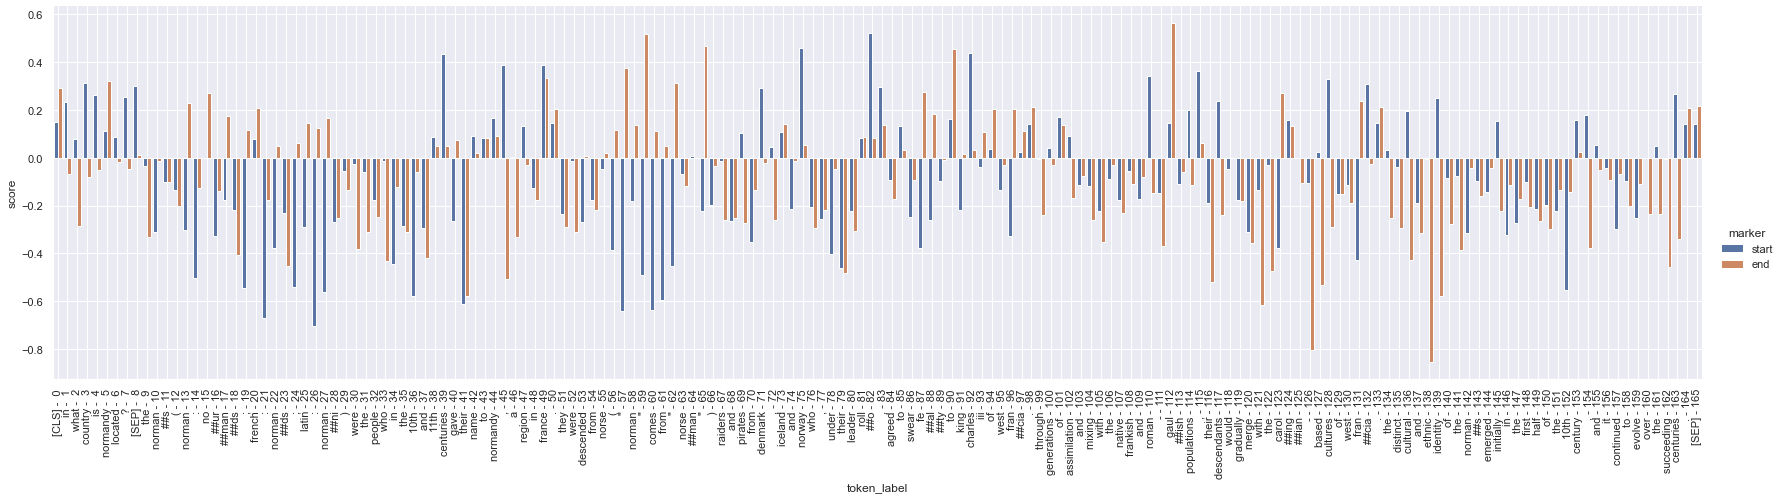

In [39]:
tokens = model.generate_text_from_token()

scores = []

token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

for (i, token_label) in enumerate(token_labels):
    scores.append({'token_label': token_label, 
                   'score': s_Scores[i],
                   'marker': 'start'})
    scores.append({'token_label': token_label, 
                   'score': e_Scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")
g.ax.grid(True)